The idea of this file is similar to standard ANOM written in ANOM_stock.ipynb except for using Ranking as a transformation method

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
number_group = 11
np.random.seed(1)

In [91]:
df = pd.read_csv("data2/real_estate.csv")
c = df.values[:,0]
v = df.values[:, 1:].T
df = pd.DataFrame(data = v, columns = c)
df = df[["priceToEarning", "priceToBook","roe","debtOnEquity","rsi"]]
df["group"] = 1

i = 2
group_dict = {1: "real_estate"}
for g in ["mineral", "production", "retail", "Technology", "tourism", "transportation","chemistry"]:
    dd = pd.read_excel("data2/" + g + ".xlsx")
    c = dd.values[:,0]
    v = dd.values[:, 1:].T
    dd = pd.DataFrame(data = v, columns = c)
    dd = dd[["priceToEarning", "priceToBook","roe","debtOnEquity" ,"rsi"]]
    dd["group"] = i
    group_dict[i] = g
    df = pd.concat([df,dd])
    i+=1
for g in ["security","Drink_food", "Bank_ind"]:
    dd = pd.read_csv("data2/" + g + ".csv")
    c = dd.values[:,0]
    v = dd.values[:, 1:].T
    dd = pd.DataFrame(data = v, columns = c)
    dd = dd[["priceToEarning", "priceToBook","roe","debtOnEquity" ,"rsi"]]
    dd["group"] = i
    group_dict[i] = g
    df = pd.concat([df,dd])
    i+=1
group_dict

{1: 'real_estate',
 2: 'mineral',
 3: 'production',
 4: 'retail',
 5: 'Technology',
 6: 'tourism',
 7: 'transportation',
 8: 'chemistry',
 9: 'security',
 10: 'Drink_food',
 11: 'Bank_ind'}

In [92]:
df[df.columns[:-1]] = df[df.columns[:-1]].apply(pd.to_numeric)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 0 to 19
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   priceToEarning  180 non-null    float64
 1   priceToBook     180 non-null    float64
 2   roe             180 non-null    float64
 3   debtOnEquity    180 non-null    float64
 4   rsi             180 non-null    float64
 5   group           180 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 9.8 KB


In [93]:
df.head()

,priceToEarning,priceToBook,roe,debtOnEquity,rsi,group
0,36.6,0.8,0.022,1.4,57.2,1
1,6.8,1.6,0.251,0.2,58.9,1
2,28.1,1.8,0.065,1.4,47.1,1
3,65.9,4.9,0.076,0.9,54.7,1
4,18.8,1.8,0.103,0.1,60.6,1


In [94]:
for col in df.columns[:-1]:
    df[col] = df[col].rank()

In [95]:
df.head()


,priceToEarning,priceToBook,roe,debtOnEquity,rsi,group
0,145.0,49.0,59.5,132.5,75.0,1
1,55.0,127.0,171.5,47.5,87.5,1
2,137.0,140.5,94.5,132.5,28.0,1
3,165.0,175.5,106.5,106.5,60.0,1
4,117.0,140.5,123.5,34.5,98.0,1


In [96]:
lis_group= []

for i in range(1,number_group+1):
  lis_group.append(df.loc[df["group"] == i].drop(["group"],axis = 1))
  

std in priceToBook seems homogeneous enough (better than not using ranks)

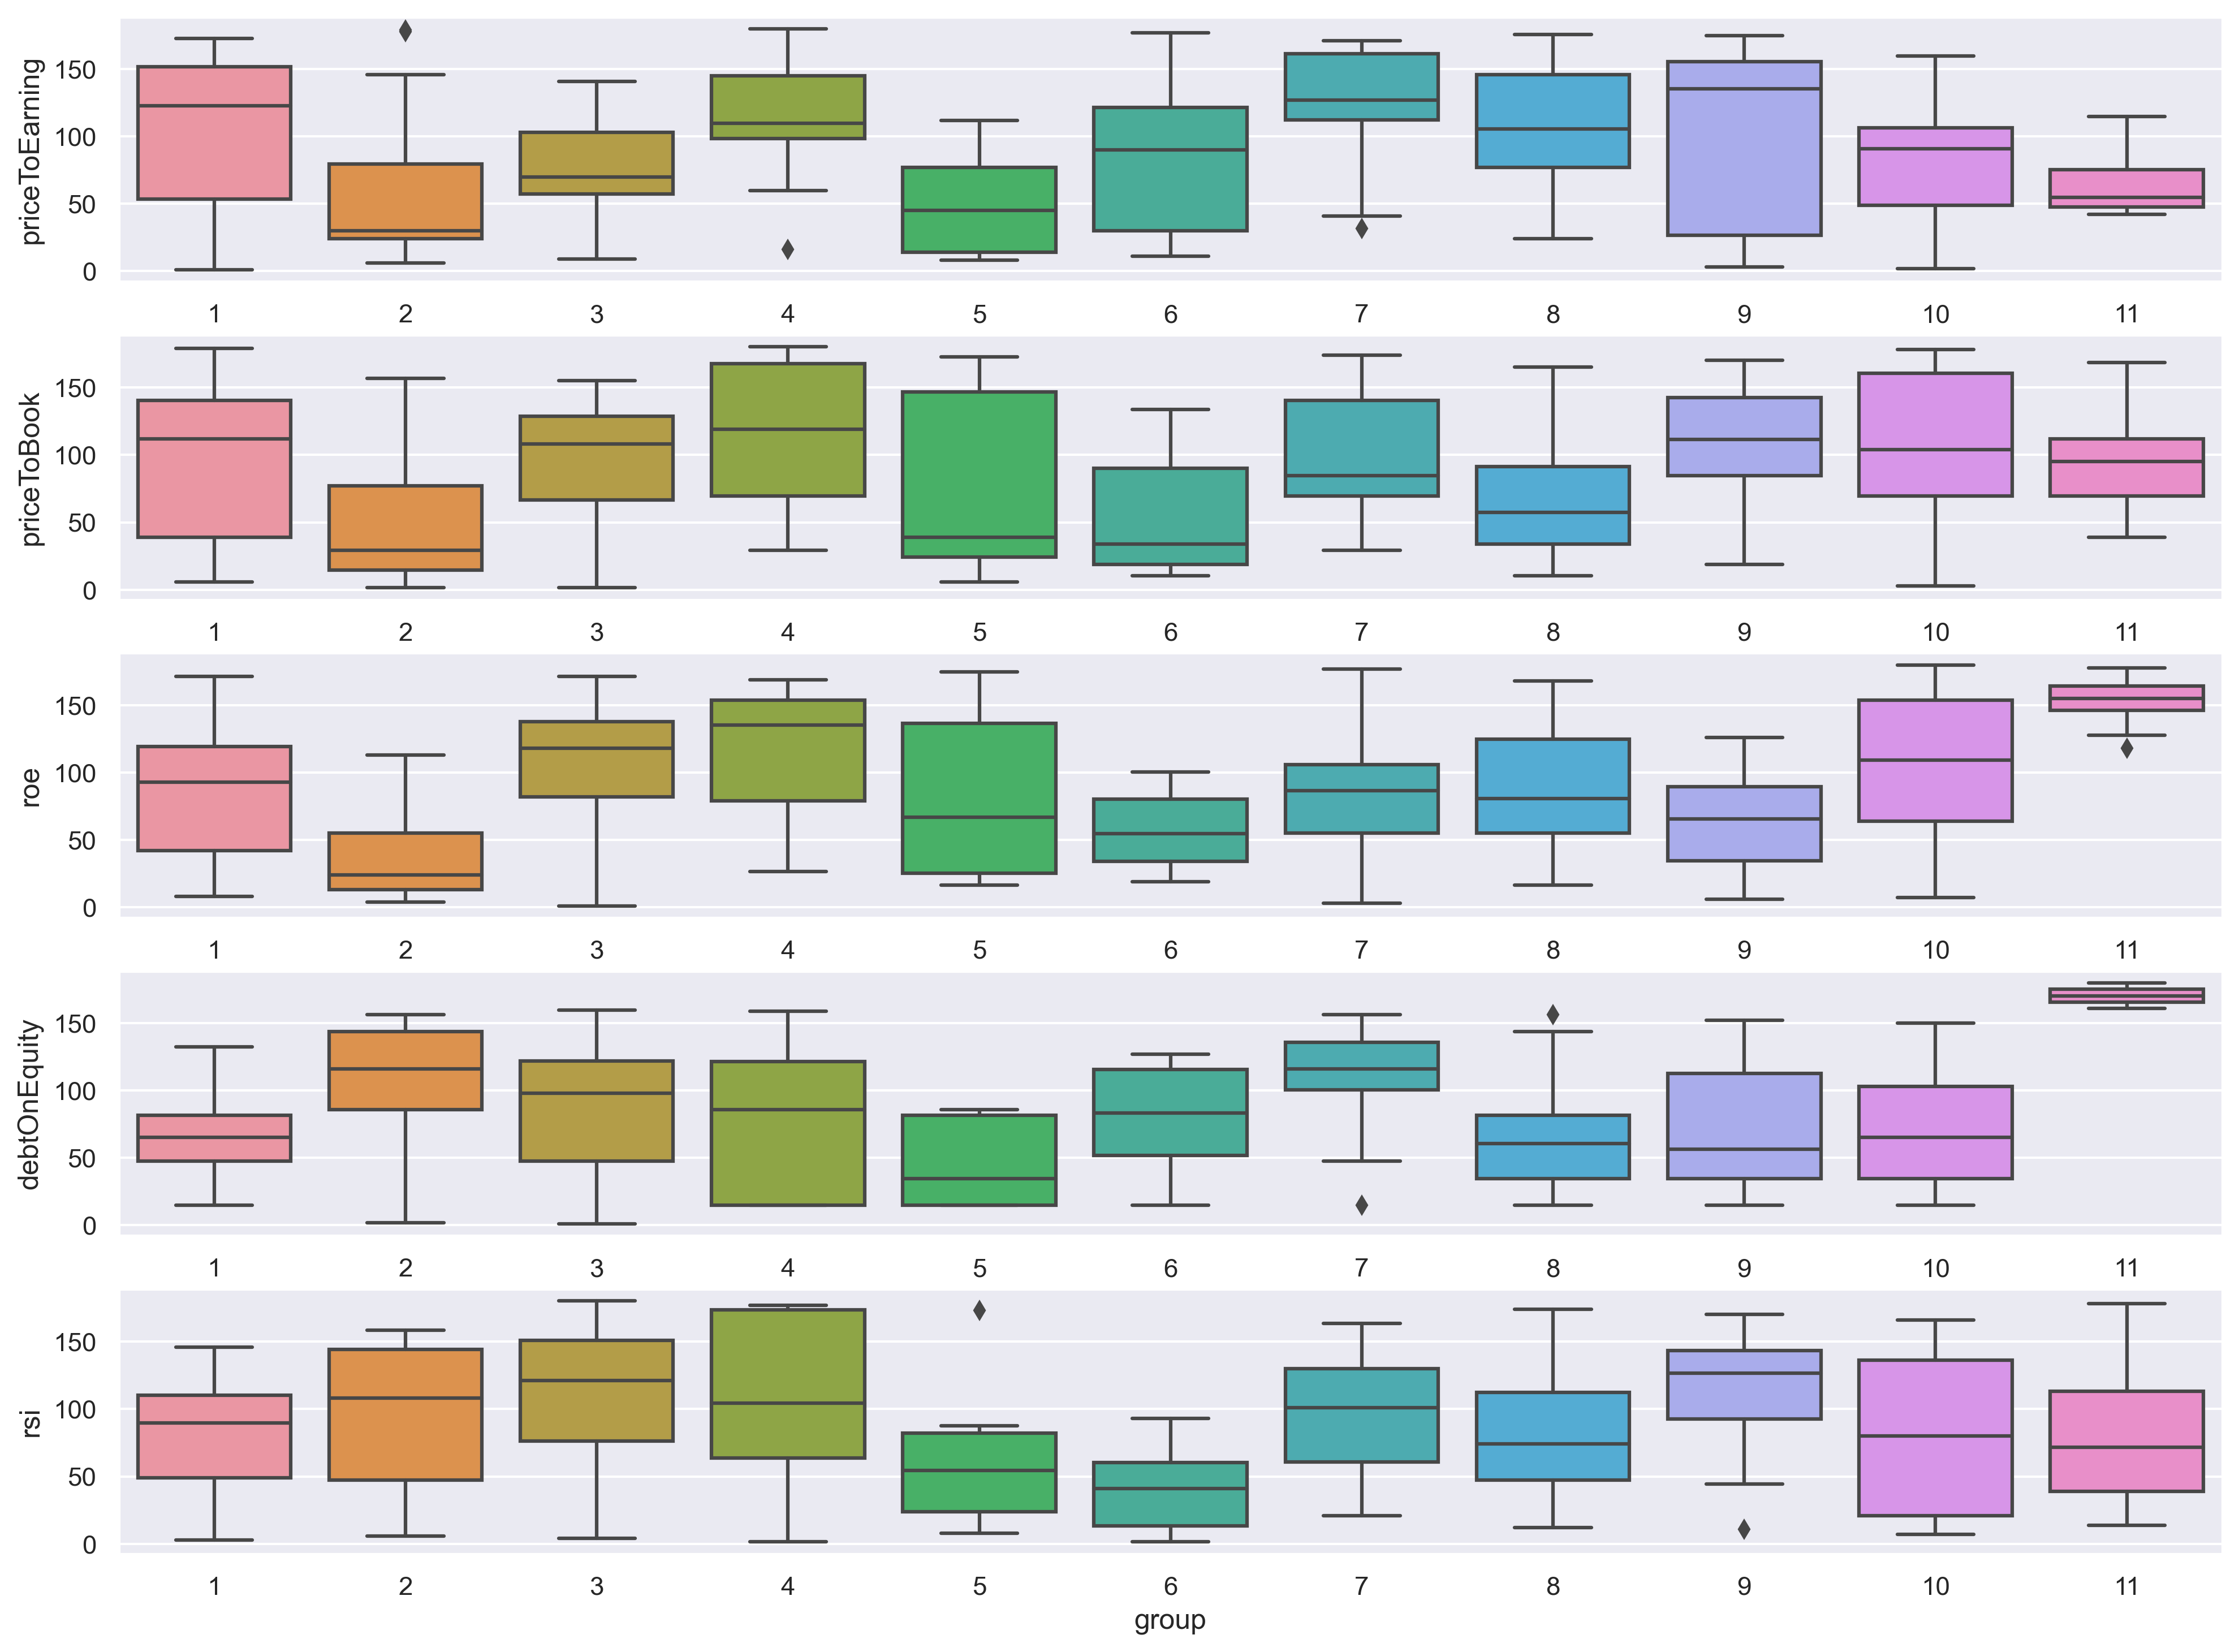

In [99]:
figs, axs = plt.subplots(nrows=5,figsize = (16,12))
for id,col in enumerate(["priceToEarning", "priceToBook","roe","debtOnEquity" ,"rsi"]):
  ax = sns.boxplot(x = "group",y=col, data = df,ax = axs[id])

In [100]:
import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(*lis_group)
print(fvalue, pvalue)

[ 4.21633835  2.98226635  8.99847939 11.45497381  1.90470832] [3.09105468e-05 1.73829331e-03 8.22253830e-12 6.96473471e-15
 4.75486750e-02]


Different from standard anom, this f-test result shows that all categories have outliers

Now we apply ANOM to find which group is different from others

In [101]:
from scipy.stats import t
def ANOM(args, alpha = 0.05):
    if not (0 < alpha < 1):
        raise ValueError("alpha can only get values between 0 - 1")

    k = len(args)
    mean_var = np.sum([np.var(group,axis =0) for group in args],axis = 0)/(k)
    
    N = sum(len(i) for i in args)
    
    a2 = 1 - (1-alpha)**(1/k)
    df = N - k
    grand = np.mean(np.concatenate((args),axis =0),axis =0)
    h = abs(t.ppf(q = a2/2, df = df))

    result = []
    for group in args:
        ni = len(group)
        UDL = grand + np.sqrt(mean_var)*h*np.sqrt((N-ni)/(N*ni))
        LDL = grand - np.sqrt(mean_var)*h*np.sqrt((N-ni)/(N*ni))
        result.append([UDL,LDL])
        
    return grand,result
    

In [102]:
grand_mean, DL = ANOM([np.atleast_2d(g) for g in lis_group])

In [103]:
grand_mean

array([90.5, 90.5, 90.5, 90.5, 90.5])

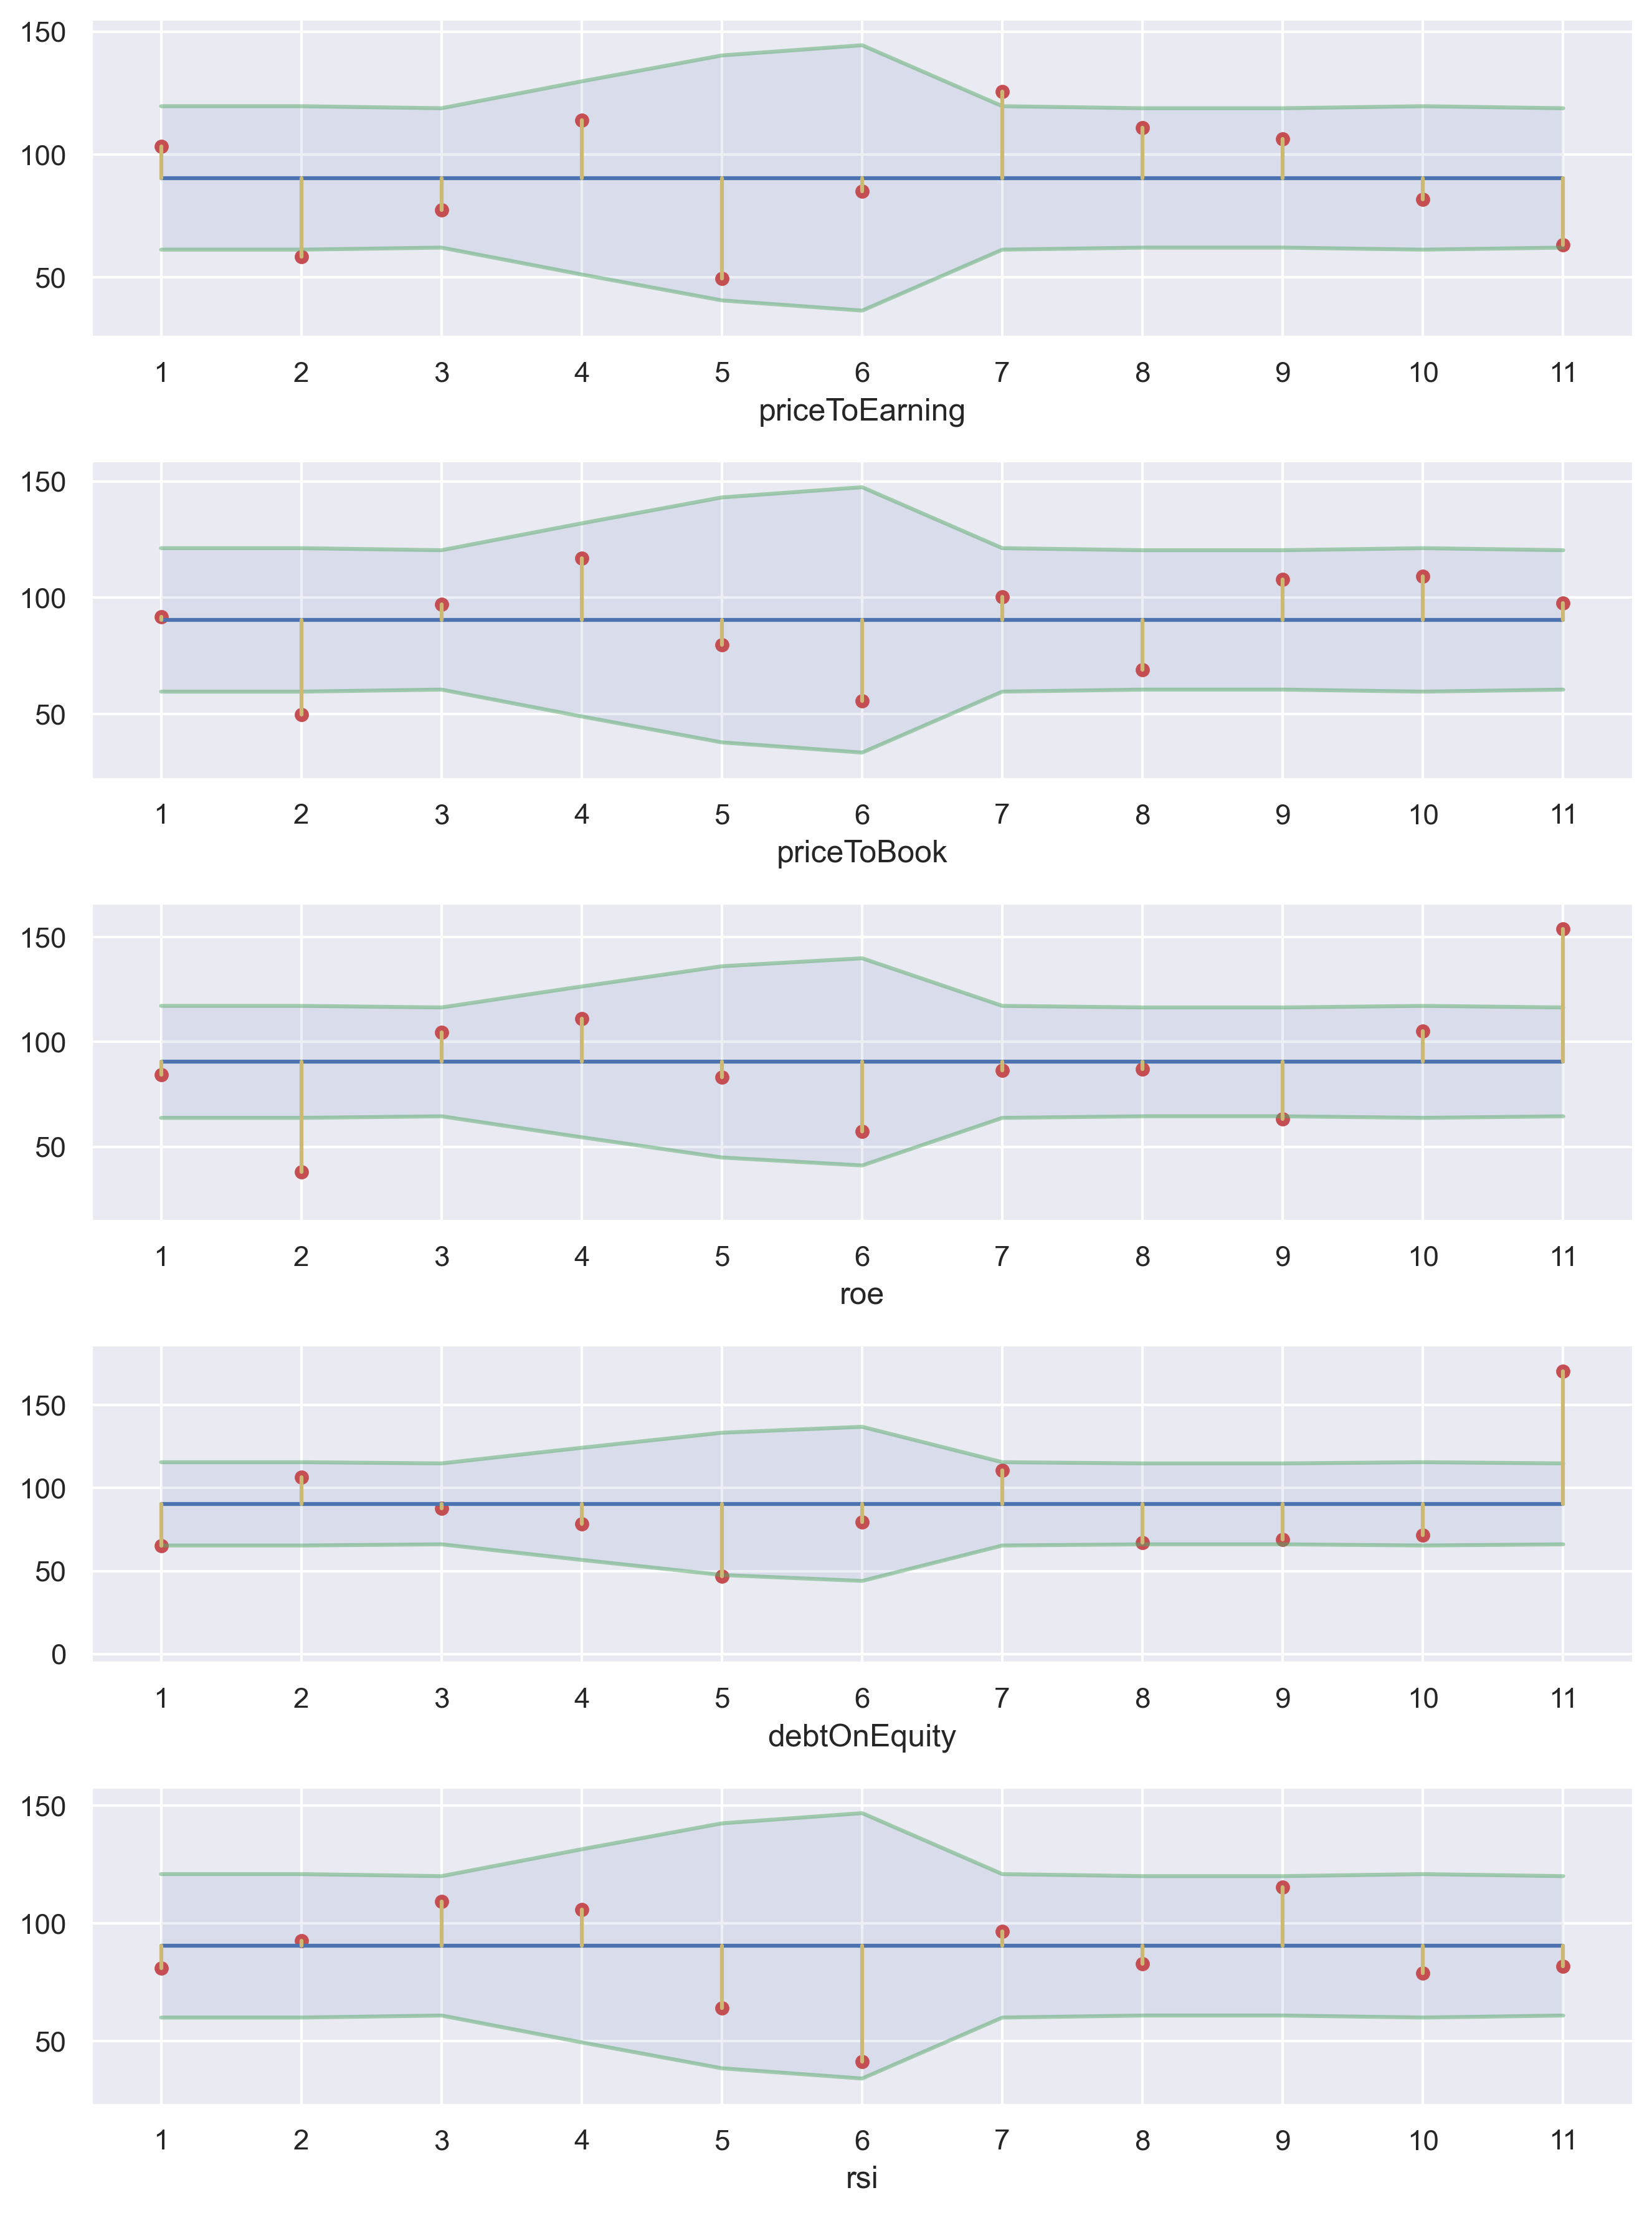

In [104]:
att_name = ["priceToEarning", "priceToBook","roe","debtOnEquity" ,"rsi"]
x = np.linspace(1,number_group,1000)
figs, axs = plt.subplots(nrows=5,figsize = (9,12))
for i in range(len(np.atleast_1d(lis_group[0])[0])):
  
  axs[i].plot(x,0*x + grand_mean[i])
  x = np.arange(1,1+len(lis_group))
  axs[i].plot(x, [DL[j][0][i] for j in range(len(DL))],'g',alpha = .5)
  axs[i].plot(x, [DL[j][1][i] for j in range(len(DL))],'g',alpha = .5)
  axs[i].fill_between(x,[DL[j][0][i] for j in range(len(DL))],[DL[j][1][i] for j in range(len(DL))],alpha=0.1)
  axs[i].scatter(x, [lis_group[j].mean()[i] for j in range(len(DL))],20,'r')
  tol = max(max(np.abs(-grand_mean[i]+[lis_group[j].mean()[i] for j in range(len(DL))]))*1.2, max([DL[k][0][i]-grand_mean[i] for k in range(len(DL))])*1.2)
  axs[i].set_ylim(grand_mean[i]-tol,grand_mean[i]+tol)
  axs[i].set_xticks(range(1,len(DL)+1))
  axs[i].set_xlabel(att_name[i])
  for j in range(1, len(DL)+1):
    axs[i].plot([j,j],[grand_mean[i],lis_group[j-1].mean()[i]],c = 'y')

figs.tight_layout()


In [105]:
group_dict

{1: 'real_estate',
 2: 'mineral',
 3: 'production',
 4: 'retail',
 5: 'Technology',
 6: 'tourism',
 7: 'transportation',
 8: 'chemistry',
 9: 'security',
 10: 'Drink_food',
 11: 'Bank_ind'}

The difference between the two methods is because of the effect of noise in data. As we already know, stock data is not very trustable.